In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [14]:
data_folder = "data"
folders = ["angry", "happy", "sad"]
allowed_formats = ["png", "jpg", "jpeg"]

In [30]:
data = []
labels = []
for folder in folders:
    path = os.path.join(data_folder, folder)
    i = 0
    for image_path in os.listdir(path):
        final_image_path = os.path.join(path, image_path)
        if os.path.splitext(final_image_path)[1][1:] in allowed_formats:
            try:
                image = plt.imread(final_image_path)
                i += 1
                resized_image = resize(image, (128, 128, 3))
                data.append(resized_image)
                labels.append(folders.index(folder))
            except:
                print(f"Image with filepath {final_image_path} failed to load.")
    print(i)

Image with filepath data\angry\20240520081743_Anger.png failed to load.
82
Image with filepath data\happy\happiness2.png failed to load.
89
114


In [33]:
X = np.array(data)
X = X.swapaxes(1, 3).swapaxes(2, 3)
y = np.array(labels)
# np.save("../X.npy", X)
# np.save("../y.npy", y)

In [35]:
# UNCOMMENT IF externally stored variables for data exist
# X = np.load("../X.npy")
# y = np.load("../y.npy")

In [36]:
X_gpu = torch.tensor(X)
y_gpu = torch.tensor(y)
y_gpu = F.one_hot(y_gpu.long())


class ImageDataset(Dataset):
    def __init__(self, X_gpu, y_gpu):
        self.X_gpu = X_gpu
        self.y_gpu = y_gpu

    def __len__(self):
        return len(self.X_gpu)

    def __getitem__(self, i):
        return self.X_gpu[i], self.y_gpu[i]

dataset = ImageDataset(X_gpu, y_gpu)

In [37]:
X_train, X_test = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(X_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=16, shuffle=True)

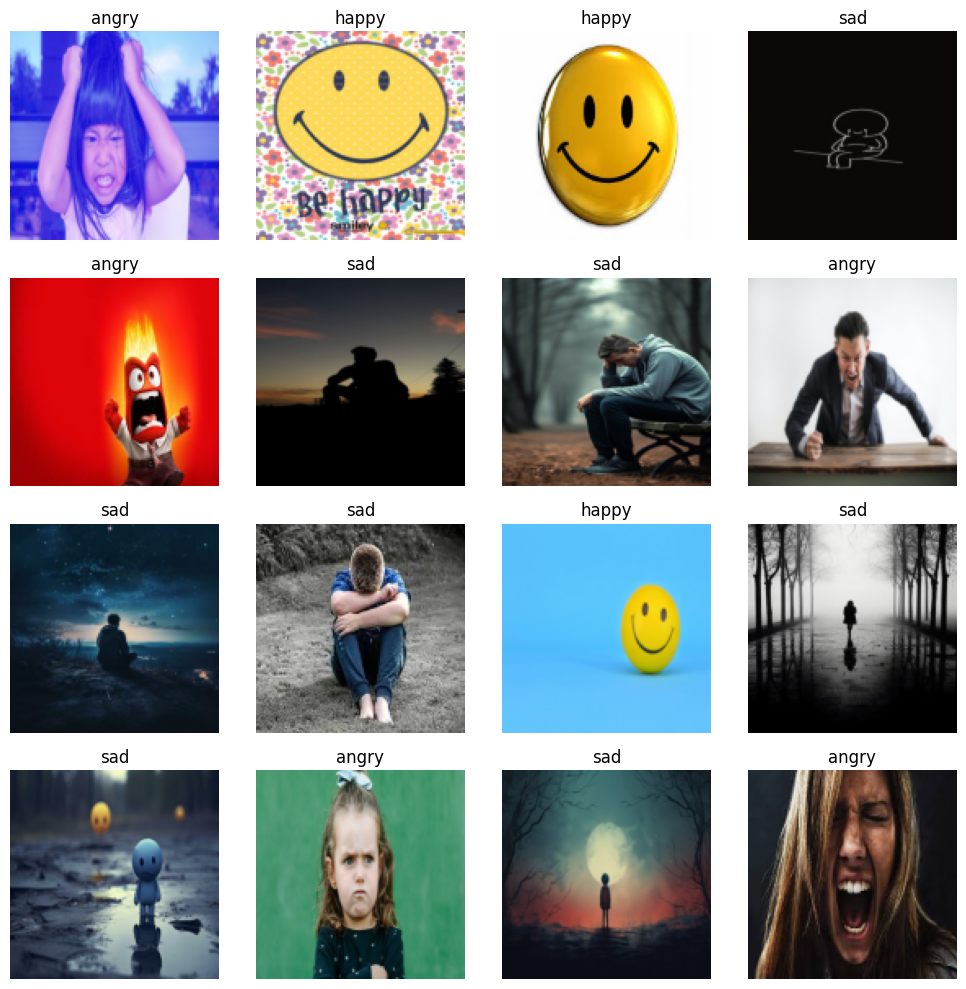

In [28]:
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(folders[labels[i].argmax().item()])
    ax.axis('off')
plt.tight_layout()
plt.show()